In [4]:
!pip install tensorflow matplotlib opencv-python

In [6]:
#IMPORTING DEPENDENCIES

import cv2
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [8]:
#IMPORTING NECESSARY LIBRARIES AND FRAMEWORKS

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten

In [10]:
#ASSIGNING STORAGE PATH

POS_PATH = os.path.join('database', 'positive')
NEG_PATH = os.path.join('database', 'negative')
ANC_PATH = os.path.join('database', 'anchor')

In [12]:
# Create directories if they don't exist
os.makedirs(ANC_PATH, exist_ok=True)
os.makedirs(POS_PATH, exist_ok=True)
os.makedirs(NEG_PATH, exist_ok=True)

In [14]:
#IMPORTING UNIVERSALLY UNIQUE IDENTIFIER

import uuid
uuid.uuid1()

UUID('0ebe5fbe-2448-11ef-bfa7-84a93e422fae')

In [16]:
#ACCESSING MY SYSTEM'S WEBCAM

cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250, 200:200+250, :]
    
#CAPTURING IMAGES AND STORING IN THE ANCHOR DIRECTORY    
    
    if cv2.waitKey(1) & 0XFF == ord('a'):
            imagename = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
            cv2.imwrite(imagename, frame)

#CAPTURING IMAGES AND STORING IN THE POSITIVE DIRECTORY

    if cv2.waitKey(1) & 0XFF == ord('p'):
            imagename = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
            cv2.imwrite(imagename, frame)
    
    cv2.imshow('Image Collection', frame)

#CLOSING THE WEBCAM

    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()

In [18]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(250)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(250)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(250)

In [20]:
#CREATING A PREPROCESS FUNCTION
#THIS FUNCTION RESIZES THE IMAGE

def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (100,100))
    img = img / 255.0
    return img

In [22]:
#CONCATENATING THE POSITIVE AND NEGATIVE DIRECTORIES TO ONE DATASET FOR TRAINING

positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
data = positives.concatenate(negatives)

In [24]:
#CREATING ANOTHER PREPROCESSING FUNCTION

def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [26]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [28]:
#ASSIGNING 80% OF THE ENTIRE DATASET FOR TRAINING
train_data = data.take(round(len(data)*.8))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)          

In [30]:
#ASSIGNING 20% OF THE ENTIRE DATASET FOR TESTING THE MODEL
test_data = data.skip(round(len(data)*.8))
test_data = test_data.take(round(len(data)*.2))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [32]:
#CREATING THE EMBEDDED LAYER OF THE MODEL

def make_embedding():
    inp = Input(shape = (100, 100, 3), name = 'input_image')
    
    c1 = Conv2D(64,(10, 10), activation = 'relu')(inp)
    m1 = MaxPooling2D(64,(2,2), padding = 'same')(c1)
    
    c2 = Conv2D(128,(7,7), activation = 'relu')(m1)
    m2 = MaxPooling2D(64,(2,2), padding = 'same')(c2)
    
    c3 = Conv2D(128,(4,4), activation = 'relu')(m2)
    m3 = MaxPooling2D(64,(2,2), padding = 'same')(c3)
    
    c4 = Conv2D(256,(4,4), activation = 'relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation = 'sigmoid')(f1)
    
    return Model(inputs=[inp], outputs=[d1] ,name= 'embedding')

In [34]:
#CHECKING TO SEE IF THE EMBEDDED LAYER HAS BEEN SUCESSFULLY CREATED

embedding = make_embedding()
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
#CREATING MY L1DIST LAYER

class L1Dist(Layer):
    def call(self, input_embedding, validation_embedding):
        input_tensor = tf.convert_to_tensor(input_embedding)
        validation_tensor = tf.convert_to_tensor(validation_embedding)
        return tf.math.abs(input_tensor - validation_tensor)


In [72]:
#CREATING MY INPUT IMAGE VARIABLE
input_img = Input(name = 'input_img', shape = (100, 100, 3))
embedding(input_img)

[<KerasTensor shape=(None, 4096), dtype=float32, sparse=False, name=keras_tensor_28>]

In [74]:
#CREATING MY VALIDATION IMAGE VARIABLE
validation_img = Input(name = 'validation_img', shape = (100, 100, 3))
embedding(validation_img)

[<KerasTensor shape=(None, 4096), dtype=float32, sparse=False, name=keras_tensor_29>]

In [76]:
#ASSIGNING MY L1DIST CLASS TO THE SIAMESE MODEL LAYER
siamese_layer = L1Dist()
siamese_layer(embedding(input_img), embedding(validation_img) )

<KerasTensor shape=(1, None, 4096), dtype=float32, sparse=False, name=keras_tensor_32>

In [78]:
#CREATING THE SIAMESE MODEL

def make_siamese_model():
    
    input_img = Input(name = 'input_img', shape = (100, 100, 3))
    
    validation_img = Input(name = 'validation_img', shape = (100, 100, 3))
    
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_img), embedding(validation_img))
    
    classifier = Dense(1, activation='sigmoid')(distances)
    
    
    model_1 = Model(inputs=[input_img, validation_img], outputs=classifier, name='SiameseNetwork')
    
    return model_1


In [80]:
#CHECKING THE SUMMARY OF THE SIAMESE MODEL

siamese_network = make_siamese_model()
siamese_network.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_5 (L1Dist)  │ (1, None, 4096)   │          0 │ embedding[18][0], │
│                     │                   │            │ embedding[19][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (1, None, 1)      │      4,097 │ l1_dist_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [82]:
#ASSIGNING MY BINARY LOSS 

binary_cross_loss = tf.losses.BinaryCrossentropy()

#ASSIGNING MY OPTIMIZER

optimizer = tf.keras.optimizers.Adam(1e-4)

In [84]:
siamese_model = make_siamese_model()
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(optimizer=optimizer, siamese_model=siamese_model)

In [106]:
from keras.losses import binary_crossentropy
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        x = batch[:2]
        y_true = batch[2]
        
        y_pred = siamese_model(x, training = True)
        y_pred = tf.squeeze(y_pred, axis=-1)
        loss = binary_crossentropy(y_true, y_pred)
    
        
    grad = tape.gradient(loss, siamese_model.trainable_variables)
        
    optimizer.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    return loss





In [108]:
#CREATING MY TRAIN FUNCTION

def train(data, EPOCHS):
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch{}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        for idx, batch in enumerate(data):
            train_step(batch)
            progbar.update(idx+1)
            
            if epoch % 10 == 0:
                checkpoint.save(file_prefix=checkpoint_prefix)

In [110]:
#ASSIGNING EPOCH VALUE

EPOCHS = 10

In [114]:
#IMPORTING THE ACCURACY METRICS

from tensorflow.keras.metrics import Precision, Recall

In [116]:
#TESTING THE INPUT AND VALIDATION IMAGES

test_input, test_val, y_true = test_data.as_numpy_iterator().next()
test_input

array([[[[0.7443628 , 0.7014706 , 0.6693627 ],
         [0.7414216 , 0.7085784 , 0.67058825],
         [0.72745097, 0.70906866, 0.6664216 ],
         ...,
         [0.70906866, 0.7169118 , 0.7056373 ],
         [0.7254902 , 0.7384804 , 0.74852943],
         [0.74852943, 0.7642157 , 0.7759804 ]],

        [[0.7264706 , 0.7088235 , 0.6862745 ],
         [0.7254902 , 0.7056373 , 0.69166666],
         [0.73088235, 0.7088235 , 0.69558823],
         ...,
         [0.69803923, 0.70490193, 0.70392156],
         [0.70490193, 0.7088235 , 0.7237745 ],
         [0.71642154, 0.7291667 , 0.74191177]],

        [[0.7262255 , 0.7252451 , 0.6968137 ],
         [0.71960783, 0.7019608 , 0.70098037],
         [0.74191177, 0.70955884, 0.7144608 ],
         ...,
         [0.689951  , 0.7012255 , 0.7022059 ],
         [0.7085784 , 0.7125    , 0.7289216 ],
         [0.7083333 , 0.70710784, 0.7235294 ]],

        ...,

        [[0.64460784, 0.5772059 , 0.5365196 ],
         [0.61446077, 0.56397057, 0.5240196 ]

In [118]:
test_val

array([[[[0.00000000e+00, 3.92156886e-03, 0.00000000e+00],
         [0.00000000e+00, 2.94117653e-03, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
         [6.88970566e-01, 6.80147052e-01, 7.27696061e-01],
         [6.75735295e-01, 6.67647064e-01, 6.84803903e-01],
         [6.57598019e-01, 6.64705873e-01, 6.41176462e-01]],

        [[0.00000000e+00, 2.94117653e-03, 0.00000000e+00],
         [0.00000000e+00, 3.18627455e-03, 0.00000000e+00],
         [0.00000000e+00, 9.80392215e-04, 0.00000000e+00],
         ...,
         [6.98039234e-01, 6.84313715e-01, 7.23284304e-01],
         [6.83823526e-01, 6.60294116e-01, 6.47794127e-01],
         [6.31127477e-01, 5.99509776e-01, 5.29656887e-01]],

        [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 1.71568629e-03, 0.00000000e+00],
         [0.00000000e+00, 3.92156886e-03, 0.00000000e+00],
         ...,
         [6.92892134e-01, 6.83578432e-01, 7.30637252e-01],
         [

In [120]:
y_true

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
      dtype=float32)

In [122]:
#THE PREDICTION STATEMENT

y_pred = siamese_model.predict([test_input, test_val])
y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


array([[[0.5024926 ],
        [0.5030795 ],
        [0.50211823],
        [0.50271887],
        [0.50037867],
        [0.5031866 ],
        [0.50236976],
        [0.5004749 ],
        [0.50304264],
        [0.50025016],
        [0.5009366 ],
        [0.5021392 ],
        [0.5002241 ],
        [0.50290585],
        [0.50179493],
        [0.50236475]]], dtype=float32)

In [126]:
import numpy as np

# Assuming y_pred is a NumPy array
binary_predictions = np.where(y_pred > 0.5, 1, 0)


In [130]:
#TESTING THE RECALL METRICS

m = Recall()
m.update_state(y_true, y_pred)
m.result().numpy()

1.0

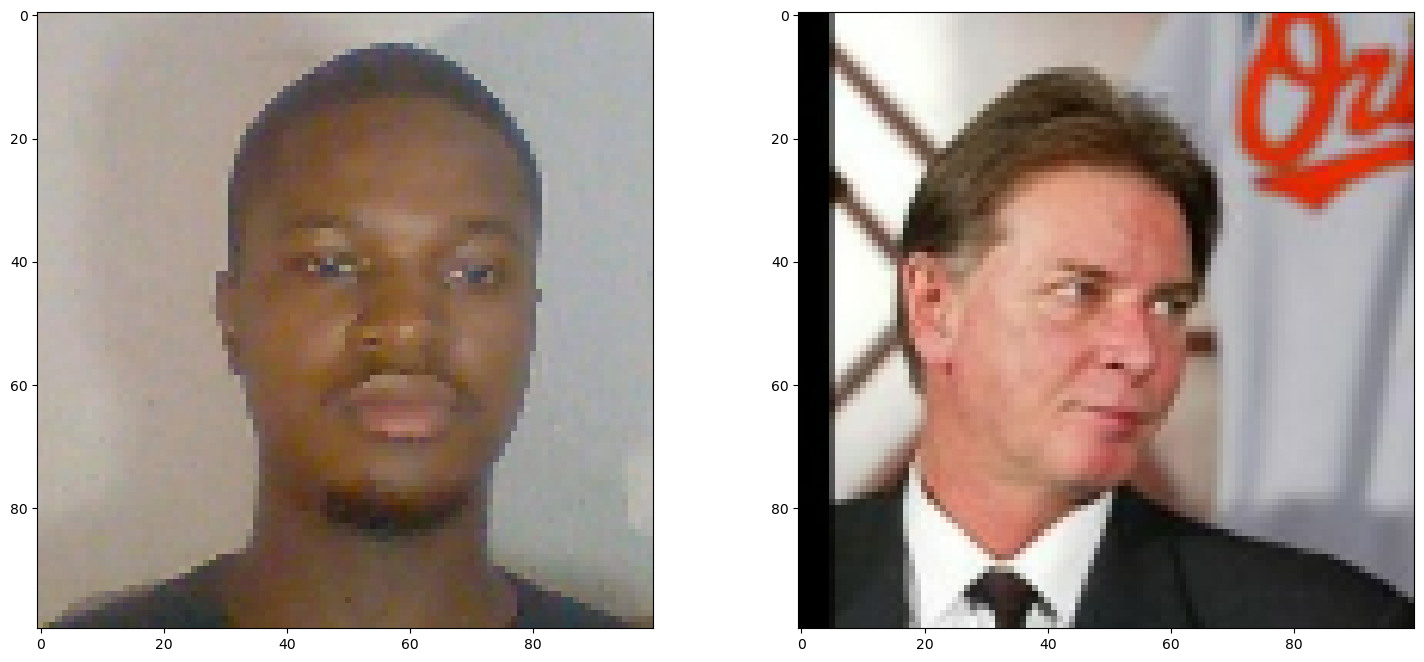

In [132]:
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
plt.imshow(test_input[0])
plt.subplot(1,2,2)
plt.imshow(test_val[0])
plt.show()

In [136]:
#SAVING THE MODEL
siamese_model.save('my_model.keras')

In [138]:
#COMPILING THE MODEL

model = tf.keras.models.load_model('my_model.keras', custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [140]:
#RUNNING A PREDICTION TEST USING THE TEST INPUT AND TEST VALIDATION IMAGES

model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


array([[[0.5024926 ],
        [0.5030795 ],
        [0.50211823],
        [0.50271887],
        [0.50037867],
        [0.5031866 ],
        [0.50236976],
        [0.5004749 ],
        [0.50304264],
        [0.50025016],
        [0.5009366 ],
        [0.5021392 ],
        [0.5002241 ],
        [0.50290585],
        [0.50179493],
        [0.50236475]]], dtype=float32)

In [142]:
#WRITING THE VERIFICATION FUNCTION

def verify(model, detection_threshold, verification_threshold):
    results = []
    for image in os.listdir(os.path.join(r'C:\Users\HP\database\application_data',r'C:\Users\HP\database\application_data\verification_images')):
        input_img = preprocess(os.path.join(r'C:\Users\HP\database\application_data', r'C:\Users\HP\database\application_data\input_image', r'C:\Users\HP\data\application_data\input_image\input_image.jpg'))
        validation_img = preprocess(os.path.join(r'C:\Users\HP\database\application_data',r'C:\Users\HP\database\application_data\verification_images', image))
        #input_validation_images = list(np.expand_dims([input_img, validation_img], axis=1))
        #result = model.predict(input_validation_images)
        #results.append(result)
        
        input_img_expanded = np.expand_dims(input_img, axis=0)
        validation_img_expanded = np.expand_dims(validation_img, axis=0)
        
        input_validation_images = [input_img_expanded, validation_img_expanded]
        result = model.predict(input_validation_images)
        results.append(result)
 #THE CODE THAT CALCULATES THE VERIFICATION

    detection = np.sum(np.array(results) > detection_threshold)
    num_verification_images = len(results)
    verification = detection / num_verification_images
    verified = verification > verification_threshold
    
    return results, verified

In [144]:
#ACCESSING THE WEBCAM TO CAPTURE THE INPUT IMAGE

cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250, 200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    if cv2.waitKey(10) & 0XFF == ord('v'):
        cv2.imwrite(os.path.join(r'C:\Users\HP\database\application_data\input_image\input_image.jpg'), frame)
        results, verified = verify(model, 0.995, 0.7)
        print(verified)
        
 #SHUTING DOWN THE WEBCAM   
    if cv2.waitKey(10) & 0XFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()   

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 874ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 